In [1]:
import praw
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package stopwords to /home/yash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

reddit = praw.Reddit(
    client_id="nyLXtnsn5fsZa93O3wU59w",        
    client_secret="bpX0DUINqReL0mKvInmW54_z3BQq9w",  
    user_agent="scraper (by u/officerballs23)",
    check_for_async=False
)

In [10]:

from datetime import datetime

# subreddits = ["Politics", "PoliticalDiscussion", "Ask_Politics"]
subreddits = ['Liberal', 'democrats', 'conservatives', 'PoliticalDiscussion',
       'Politics', 'Ask_Politics', 'AllTheLeft', 'Conservative',
       'Republican']
data = []

# Timestamp for one year ago from now
start_timestamp = (datetime.now() - pd.DateOffset(years=1)).timestamp()

for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    
    # Combine different types of post listings
    for listing_type, time_filter in [
        ("hot", None),
        ("top", "year"),
        ("controversial", "year")
    ]:
        print(f"Fetching {listing_type} posts from r/{sub} (past year only)...")
        
        # Dynamically call the appropriate method
        if time_filter and listing_type in ["top", "controversial"]:
            submissions = getattr(subreddit, listing_type)(time_filter=time_filter, limit=60)
        else:
            submissions = getattr(subreddit, listing_type)(limit=60)
        
        for submission in submissions:
            # Filter only posts from 2025
            if submission.created_utc < start_timestamp:
                continue
            
            submission.comments.replace_more(limit=0)
            post_date = datetime.utcfromtimestamp(submission.created_utc)
            
            # Estimate downvotes
            upvotes = int(submission.score * submission.upvote_ratio)
            
            for comment in submission.comments.list()[:8]:  # limit per post
                comment_date = datetime.utcfromtimestamp(comment.created_utc)
                
                data.append({
                    "subreddit": sub,
                    "post_type": listing_type,
                    "post_title": submission.title,
                    "post_body": submission.selftext,
                    "post_score": submission.score,
                    "post_upvotes": upvotes,
                    "post_downvotes": submission.score - upvotes,
                    "comment": comment.body,
                    "comment_score": comment.score,
                    "post_date": post_date,
                    "comment_date": comment_date
                })

print(f"Total comments collected: {len(data)}")


    




Fetching hot posts from r/Liberal (past year only)...
Fetching top posts from r/Liberal (past year only)...
Fetching controversial posts from r/Liberal (past year only)...
Fetching hot posts from r/democrats (past year only)...
Fetching top posts from r/democrats (past year only)...
Fetching controversial posts from r/democrats (past year only)...
Fetching hot posts from r/conservatives (past year only)...
Fetching top posts from r/conservatives (past year only)...
Fetching controversial posts from r/conservatives (past year only)...
Fetching hot posts from r/PoliticalDiscussion (past year only)...
Fetching top posts from r/PoliticalDiscussion (past year only)...
Fetching controversial posts from r/PoliticalDiscussion (past year only)...
Fetching hot posts from r/Politics (past year only)...
Fetching top posts from r/Politics (past year only)...
Fetching controversial posts from r/Politics (past year only)...
Fetching hot posts from r/Ask_Politics (past year only)...
Fetching top posts

In [11]:
df = pd.DataFrame(data)
df.head()

,subreddit,post_type,post_title,post_body,post_score,post_upvotes,post_downvotes,comment,comment_score,post_date,comment_date
0,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,Again implies he ever stopped lying.,20,2025-10-27 00:01:16,2025-10-27 00:07:39
1,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,The Ronald Reagan foundation is lead my a huge...,3,2025-10-27 00:01:16,2025-10-27 01:19:30
2,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,"According to Doug Ford, the intended audience ...",4,2025-10-27 00:01:16,2025-10-27 19:03:18
3,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,Yeah…. That’s what he does,2,2025-10-27 00:01:16,2025-10-27 00:41:56
4,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,Reagan said tariffs should be short-term lever...,1,2025-10-27 00:01:16,2025-10-28 02:14:05


In [12]:
df['subreddit'].value_counts()

subreddit
Politics               1440
PoliticalDiscussion    1421
Liberal                1341
democrats              1298
Conservative           1220
Republican             1178
Ask_Politics            919
conservatives           875
AllTheLeft              568
Name: count, dtype: int64

In [13]:
#cleaning data

df.drop(df[df['comment'] == '[deleted]'].index, inplace=True)
df.drop(df[df['comment'] == '[removed]'].index, inplace=True)

df.drop_duplicates(subset=['comment'], inplace=True)

english_stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in english_stopwords]
    return ' '.join(filtered_words)

def remove_punctuation(text):
    text = text.lower()
    return ''.join(char for char in text if char.isalnum() or char.isspace())

def remove_short_comments(text, min_length=3):
    words = text.split()
    if len(words) < min_length:
        return ''
    return text

df['comment'] = df['comment'].apply(remove_stopwords)
df['comment'] = df['comment'].apply(remove_punctuation)
df['comment'] = df['comment'].apply(lambda x: remove_short_comments(x, min_length=4))
df = df[df['comment'] != '']

df


,subreddit,post_type,post_title,post_body,post_score,post_upvotes,post_downvotes,comment,comment_score,post_date,comment_date
0,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,implies ever stopped lying,20,2025-10-27 00:01:16,2025-10-27 00:07:39
1,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,ronald reagan foundation lead huge supporter t...,3,2025-10-27 00:01:16,2025-10-27 01:19:30
2,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,according doug ford intended audience reagan r...,4,2025-10-27 00:01:16,2025-10-27 19:03:18
4,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,reagan said tariffs shortterm leverage trump t...,1,2025-10-27 00:01:16,2025-10-28 02:14:05
5,Liberal,hot,Trump lies again,He either strong-armed the Ronald Reagan Found...,123,115,8,must day ends y,1,2025-10-27 00:01:16,2025-10-27 19:02:49
...,...,...,...,...,...,...,...,...,...,...,...
10255,Republican,controversial,Musk news update,,0,0,0,news fart someones general direction now appoi...,-14,2025-02-02 00:22:59,2025-02-02 02:59:57
10256,Republican,controversial,Musk news update,,0,0,0,already saved 46 billion even 2 weeks,-17,2025-02-02 00:22:59,2025-02-02 01:32:55
10257,Republican,controversial,Musk news update,,0,0,0,op republican whatsoever trying stur subreddit...,0,2025-02-02 00:22:59,2025-02-02 19:29:04
10258,Republican,controversial,Musk news update,,0,0,0,access records hes operating bank account wan...,-12,2025-02-02 00:22:59,2025-02-02 02:26:19


In [14]:
tokens = " ".join(df['comment']).split()
word_counts = Counter(tokens)
common_words = word_counts.most_common(20)

In [15]:
#TF-IDF Vectorization 

corpus = df['comment'].tolist()
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,   # limit to top 5000 words to reduce dimensionality
    ngram_range=(1, 2),  # include unigrams and bigrams
)

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

print("TF-IDF matrix shape:", tfidf_matrix.shape)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[2000:2010])

TF-IDF matrix shape: (7665, 5000)
['harsh' 'harvard' 'has' 'hasnt' 'hate' 'hate speech' 'hated' 'hateful'
 'hates' 'hating']


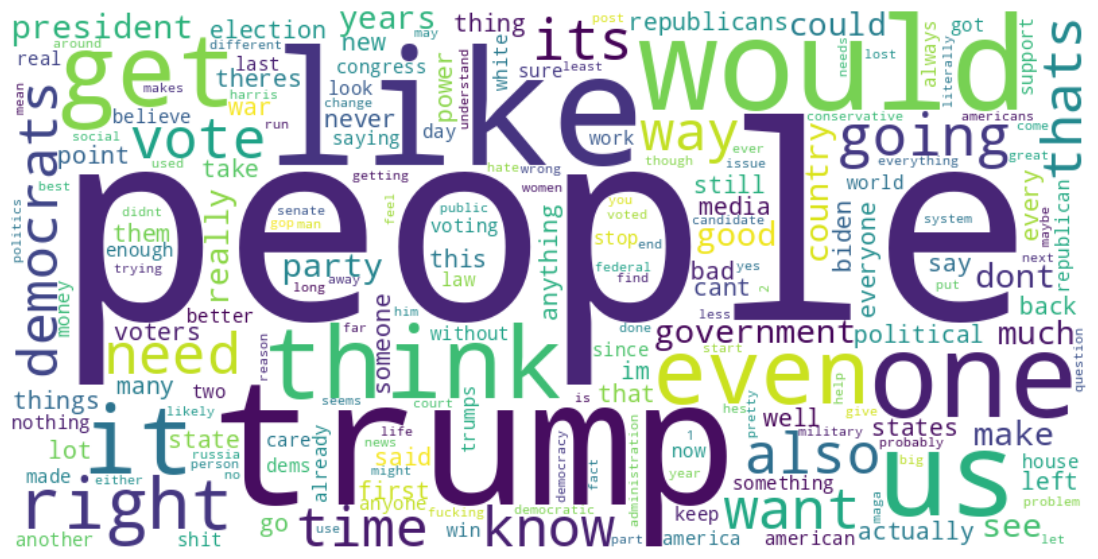

In [16]:
#Visualization 

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

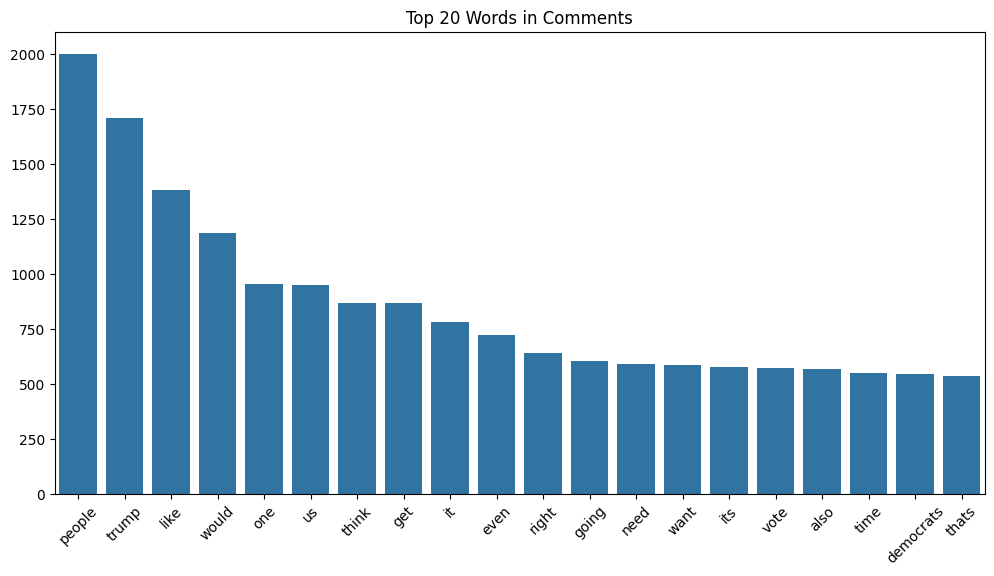

In [17]:
import seaborn as sns
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Words in Comments")
plt.show()

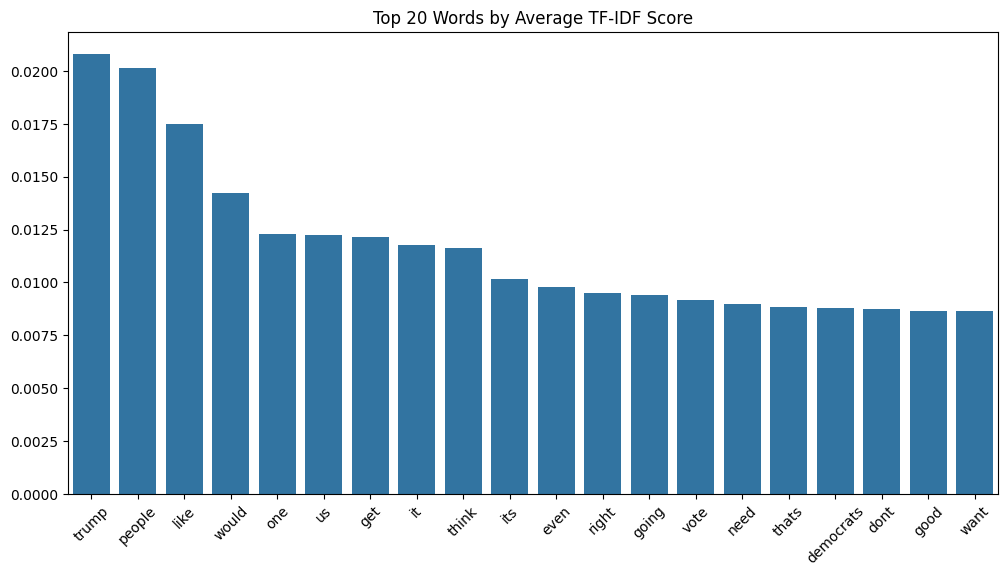

In [18]:
# Compute average TF-IDF score per feature
avg_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
top_indices = avg_tfidf.argsort()[-20:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_scores = avg_tfidf[top_indices]

plt.figure(figsize=(12,6))
sns.barplot(x=top_features, y=top_scores)
plt.xticks(rotation=45)
plt.title("Top 20 Words by Average TF-IDF Score")
plt.show()

In [19]:
avg_tfidf_per_comment = np.asarray(tfidf_matrix.mean(axis=1)).ravel()
top_comment_indices = avg_tfidf_per_comment.argsort()[-50:][::-1]
top_comments = df['comment'].iloc[top_comment_indices]
top_scores = avg_tfidf_per_comment[top_comment_indices]

top_comments

5236     maga demanding know millions protesting callin...
4140     killing charlie kirk met restraint evidence co...
7470     doctors help people without money literally al...
10179    once strength swinging heaviest sword fastest ...
4103     senator bernie sanders   understand millions a...
985      pete hegseth fox news host nazi symbols body c...
5813     see problem ai whenever becomes sufficiently i...
4381     republican party believes power principles pro...
4928     progressive era early 1900s teddy fdr super co...
6529     devil often details long short dnc rnc collude...
4931     simplify amplify message 2 tenets personal fre...
4902     live strange times heres figure it modern repu...
525      democracy the order first major challenge rece...
2467     gloves come off keep seeing today doom gloom p...
5830      although ice aware protection removal el salv...
3819      1 would describe current political climate un...
4457     candidate quality matters overstated reason po.

In [20]:
df.to_csv('reddit_political_comments_2025.csv', index=False)
